In [29]:
# --- Core Libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import shap
import optuna

# --- Scikit-learn Preprocessing & Pipelines ---
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Classifiers ---
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --- Evaluation ---
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    make_scorer,
    ConfusionMatrixDisplay
)

# --- Imbalanced Data Handling ---
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# --- UCI Dataset ---
from ucimlrepo import fetch_ucirepo


## Load data

In [71]:
mi_data = fetch_ucirepo(id=579) 
X = mi_data.data.features  
y = mi_data.data.targets 

X_cols = X.columns.tolist()
y_cols = y.columns.tolist()


In [72]:
# Feature Selection based on the importance of the features in research

selected_features = ['AGE', 'ZSN', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD',
                   'FK_STENOK', 'IBS_POST', 'SIM_GIPERT', 'IBS_NASL', 'SEX', 'nr_11',
                'nr_01','nr_02','np_01','np_04','IM_PG_P','GIPO_K','RAZRIV','JELUD_TAH','PREDS_TAH',
            'NA_BLOOD', 'KFK_BLOOD', 'AST_BLOOD', 'L_BLOOD','NA_KB', 'OTEK_LANC','FIBR_PREDS', 
            'FIBR_JELUD','DRESSLER', 'REC_IM', 'LET_IS', 'STENOK_AN', 'MP_TP_POST','DLIT_AG', 
            'ritm_ecg_p_04', 'inf_im', 'n_r_ecg_p_08', 'n_p_ecg_p_08', 'K_SH_POST', 'P_IM_STEN']

X_selected = [col for col in selected_features if col in X_cols]
y_selected = [col for col in selected_features if col in y_cols]

print("X_selected:", X_selected)
print("y_selected:", y_selected)

X_selected: ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'FK_STENOK', 'IBS_POST', 'SIM_GIPERT', 'IBS_NASL', 'SEX', 'nr_11', 'nr_01', 'nr_02', 'np_01', 'np_04', 'IM_PG_P', 'GIPO_K', 'NA_BLOOD', 'KFK_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'NA_KB', 'STENOK_AN', 'MP_TP_POST', 'DLIT_AG', 'ritm_ecg_p_04', 'inf_im', 'n_r_ecg_p_08', 'n_p_ecg_p_08', 'K_SH_POST']
y_selected: ['ZSN', 'RAZRIV', 'JELUD_TAH', 'PREDS_TAH', 'OTEK_LANC', 'FIBR_PREDS', 'FIBR_JELUD', 'DRESSLER', 'REC_IM', 'LET_IS', 'P_IM_STEN']


## Handle missing values

##### Lots of missing features (features with >10% missing examples dropped). Targets have no missing examples

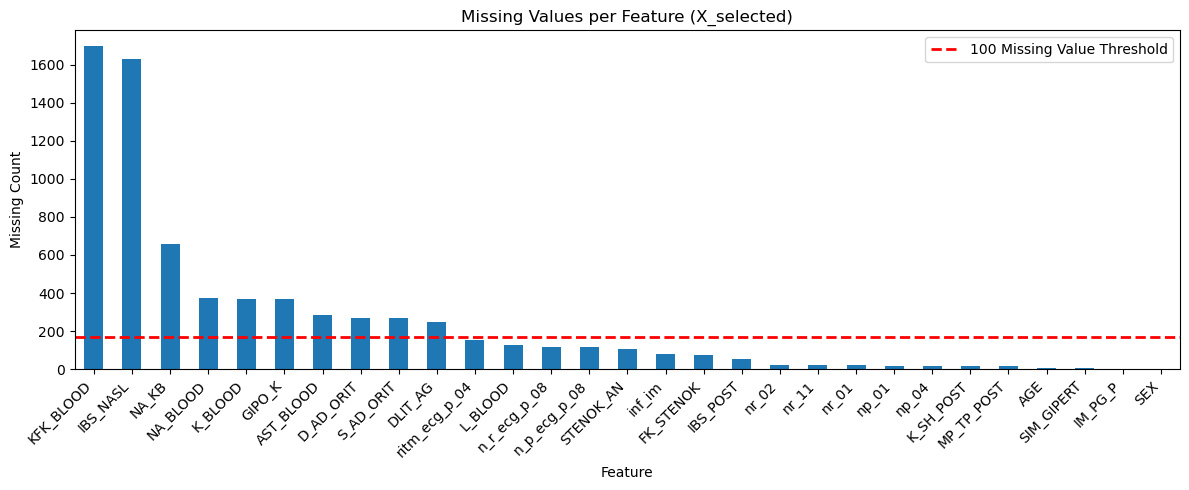

Features to drop (>10% missing): ['KFK_BLOOD', 'IBS_NASL', 'NA_KB', 'NA_BLOOD', 'K_BLOOD', 'GIPO_K', 'AST_BLOOD', 'D_AD_ORIT', 'S_AD_ORIT', 'DLIT_AG']


In [73]:
missing_counts = X[X_selected].isnull().sum().sort_values(ascending=False)

# Plot all features
missing_counts.plot.bar(figsize=(12, 5))
plt.axhline(y=170, color='red', linestyle='--', linewidth=2, label='100 Missing Value Threshold')

# Plot styling
plt.title("Missing Values per Feature (X_selected)")
plt.ylabel("Missing Count")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

threshold = 0.10 * len(X)
features_to_drop = missing_counts[missing_counts > threshold].index.tolist()
print("Features to drop (>10% missing):", features_to_drop)

In [74]:
X_clean = X[[col for col in X_selected if col not in features_to_drop]]
y_clean = y[[col for col in y_selected if col not in features_to_drop]]

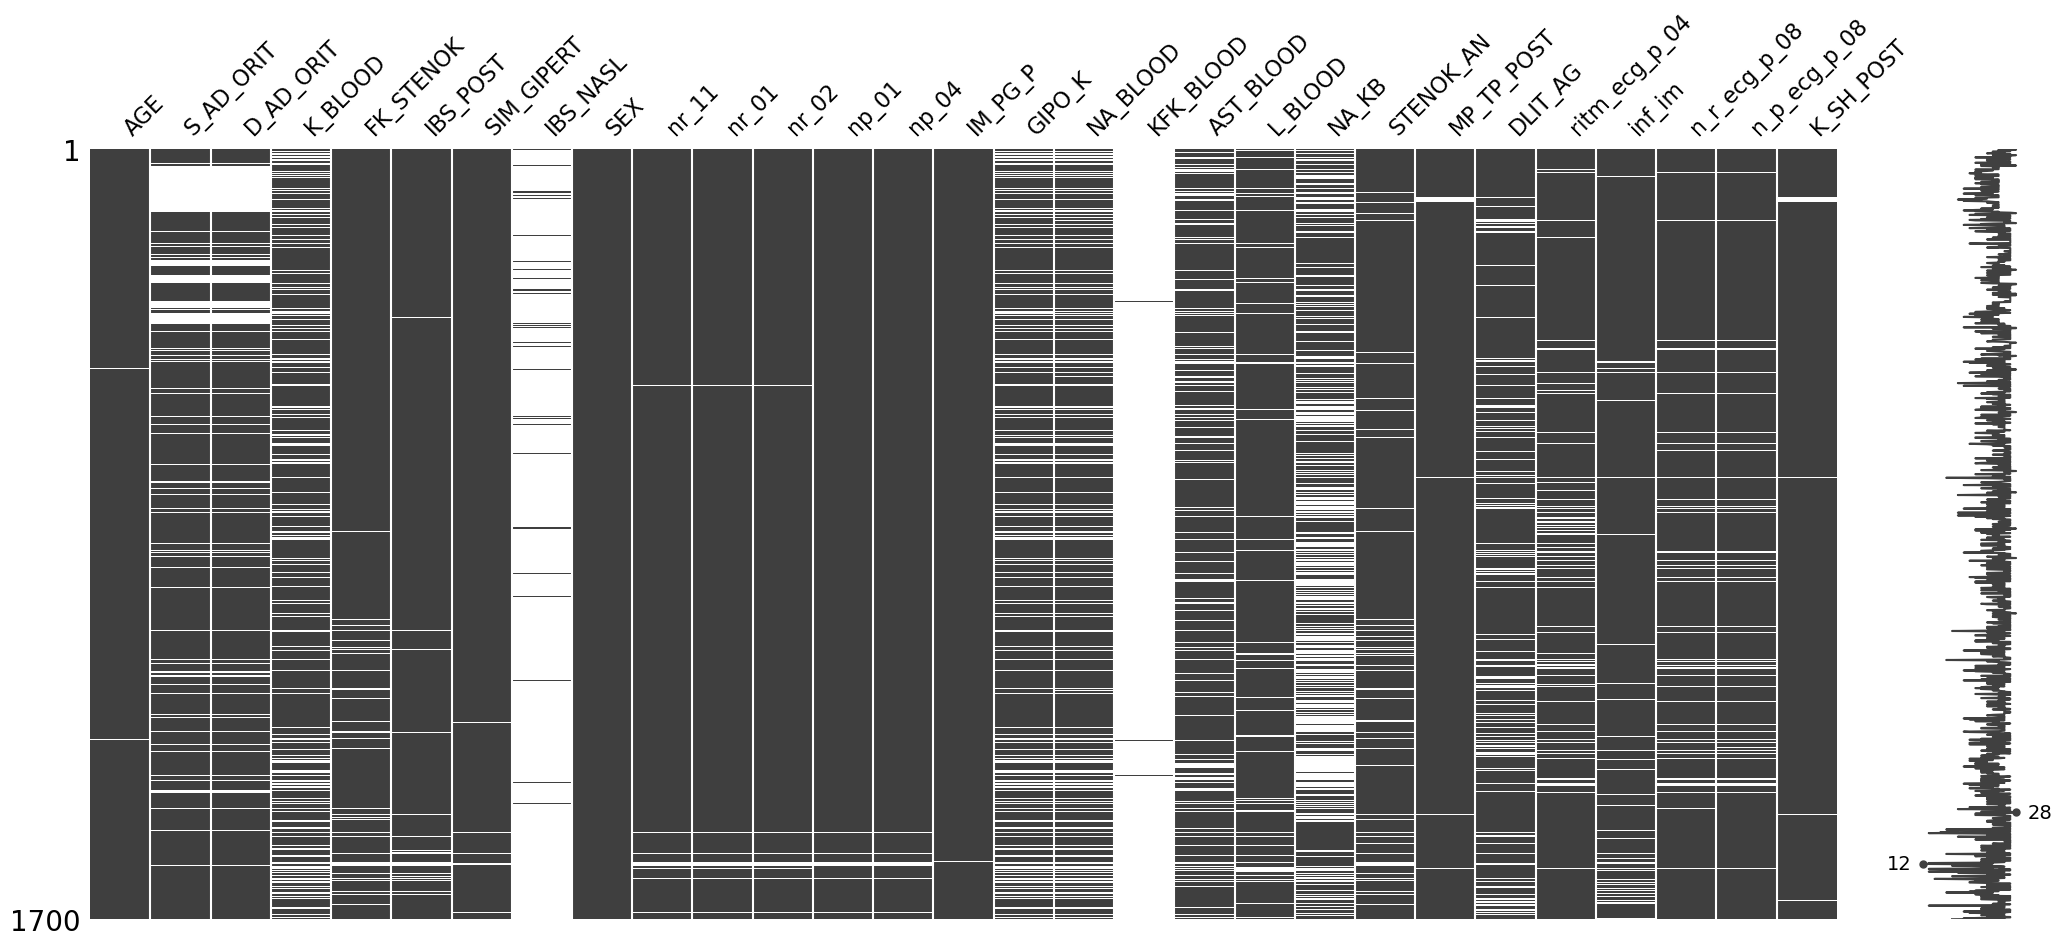

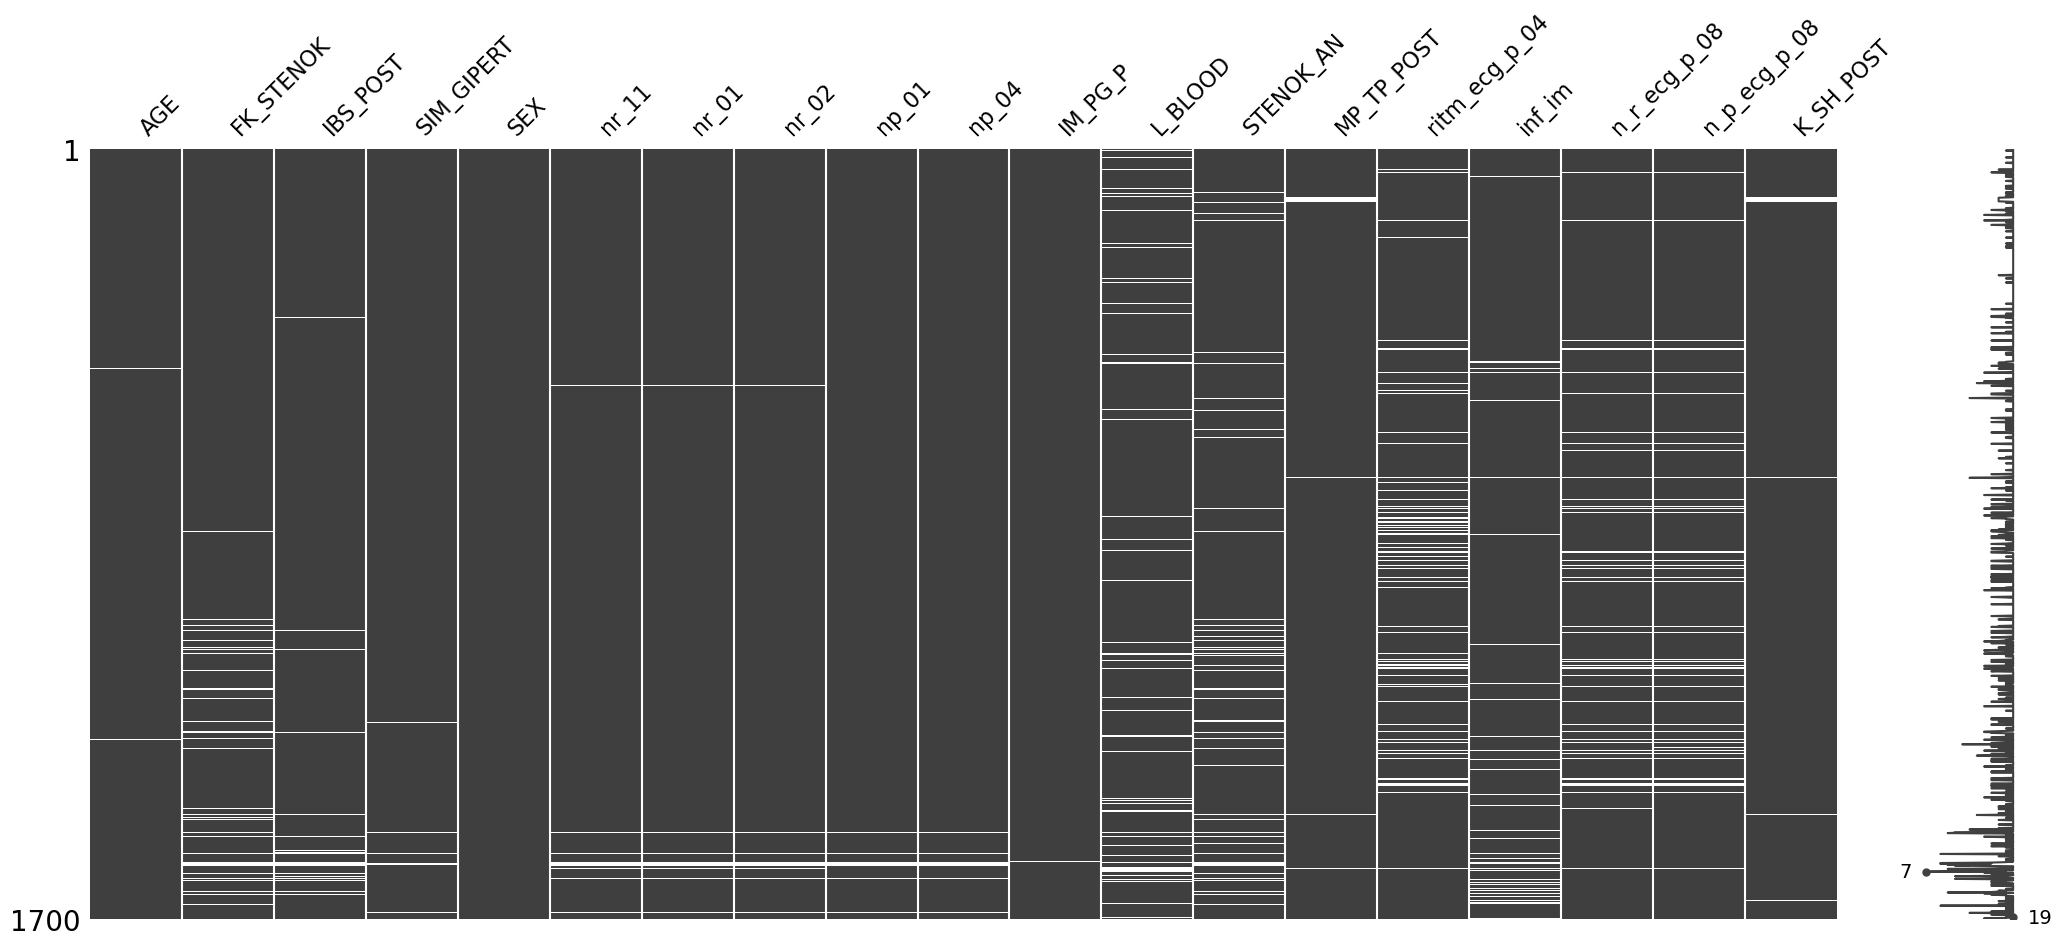

In [75]:
# Compute missing values and drop features with >10% missing ---
missing_counts = X[X_selected].isnull().sum()
threshold = 0.10 * len(X)
features_to_drop = missing_counts[missing_counts > threshold].index.tolist()

# --- Step 2: Plot Missing Value Matrix (Before) ---
msno.matrix(X[X_selected])
plt.show()

# --- Step 3: Plot Missing Value Matrix (After) ---
msno.matrix(X_clean)
plt.show()


In [76]:
# --- Feature Categorization ---
num_features = [
    'AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD',
    'NA_BLOOD', 'KFK_BLOOD', 'AST_BLOOD', 'L_BLOOD'
]

cat_features = [
    'FK_STENOK', 'IBS_POST', 'SIM_GIPERT', 'IBS_NASL',
    'SEX', 'nr_11', 'nr_01', 'nr_02', 'np_01', 'np_04',
    'IM_PG_P', 'GIPO_K', 'STENOK_AN', 'MP_TP_POST',
    'DLIT_AG', 'ritm_ecg_p_04', 'inf_im', 'n_r_ecg_p_08',
    'n_p_ecg_p_08', 'K_SH_POST', 'NA_KB'
]

num_features = [f for f in num_features if f in X_clean.columns]
cat_features = [f for f in cat_features if f in X_clean.columns]


In [77]:
# --- Preprocess Numerical Features ---
num_imputer = SimpleImputer(strategy='mean')
X_num = pd.DataFrame(num_imputer.fit_transform(X_clean[num_features]), columns=num_features)
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=num_features)

# --- Preprocess Categorical Features ---
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(cat_imputer.fit_transform(X_clean[cat_features]), columns=cat_features)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = pd.DataFrame(encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(cat_features))

# --- Combine Processed Features ---
X_cleaned = pd.concat([X_num_scaled.reset_index(drop=True), X_cat_encoded.reset_index(drop=True)], axis=1)

# --- Process Targets ---
y_cleaned = y[y_selected].copy()

In [78]:
# Convert all selected targets to categorical dtype
for col in y_selected:
    y_cleaned[col] = y_cleaned[col].astype('category')

# --- Output summary ---
print("Final numeric features:", num_features)
print("Final categorical features:", cat_features)
print("X_cleaned shape:", X_cleaned.shape)
print("y_cleaned shape:", y_cleaned.shape)

Final numeric features: ['AGE', 'L_BLOOD']
Final categorical features: ['FK_STENOK', 'IBS_POST', 'SIM_GIPERT', 'SEX', 'nr_11', 'nr_01', 'nr_02', 'np_01', 'np_04', 'IM_PG_P', 'STENOK_AN', 'MP_TP_POST', 'ritm_ecg_p_04', 'inf_im', 'n_r_ecg_p_08', 'n_p_ecg_p_08', 'K_SH_POST']
X_cleaned shape: (1700, 48)
y_cleaned shape: (1700, 11)


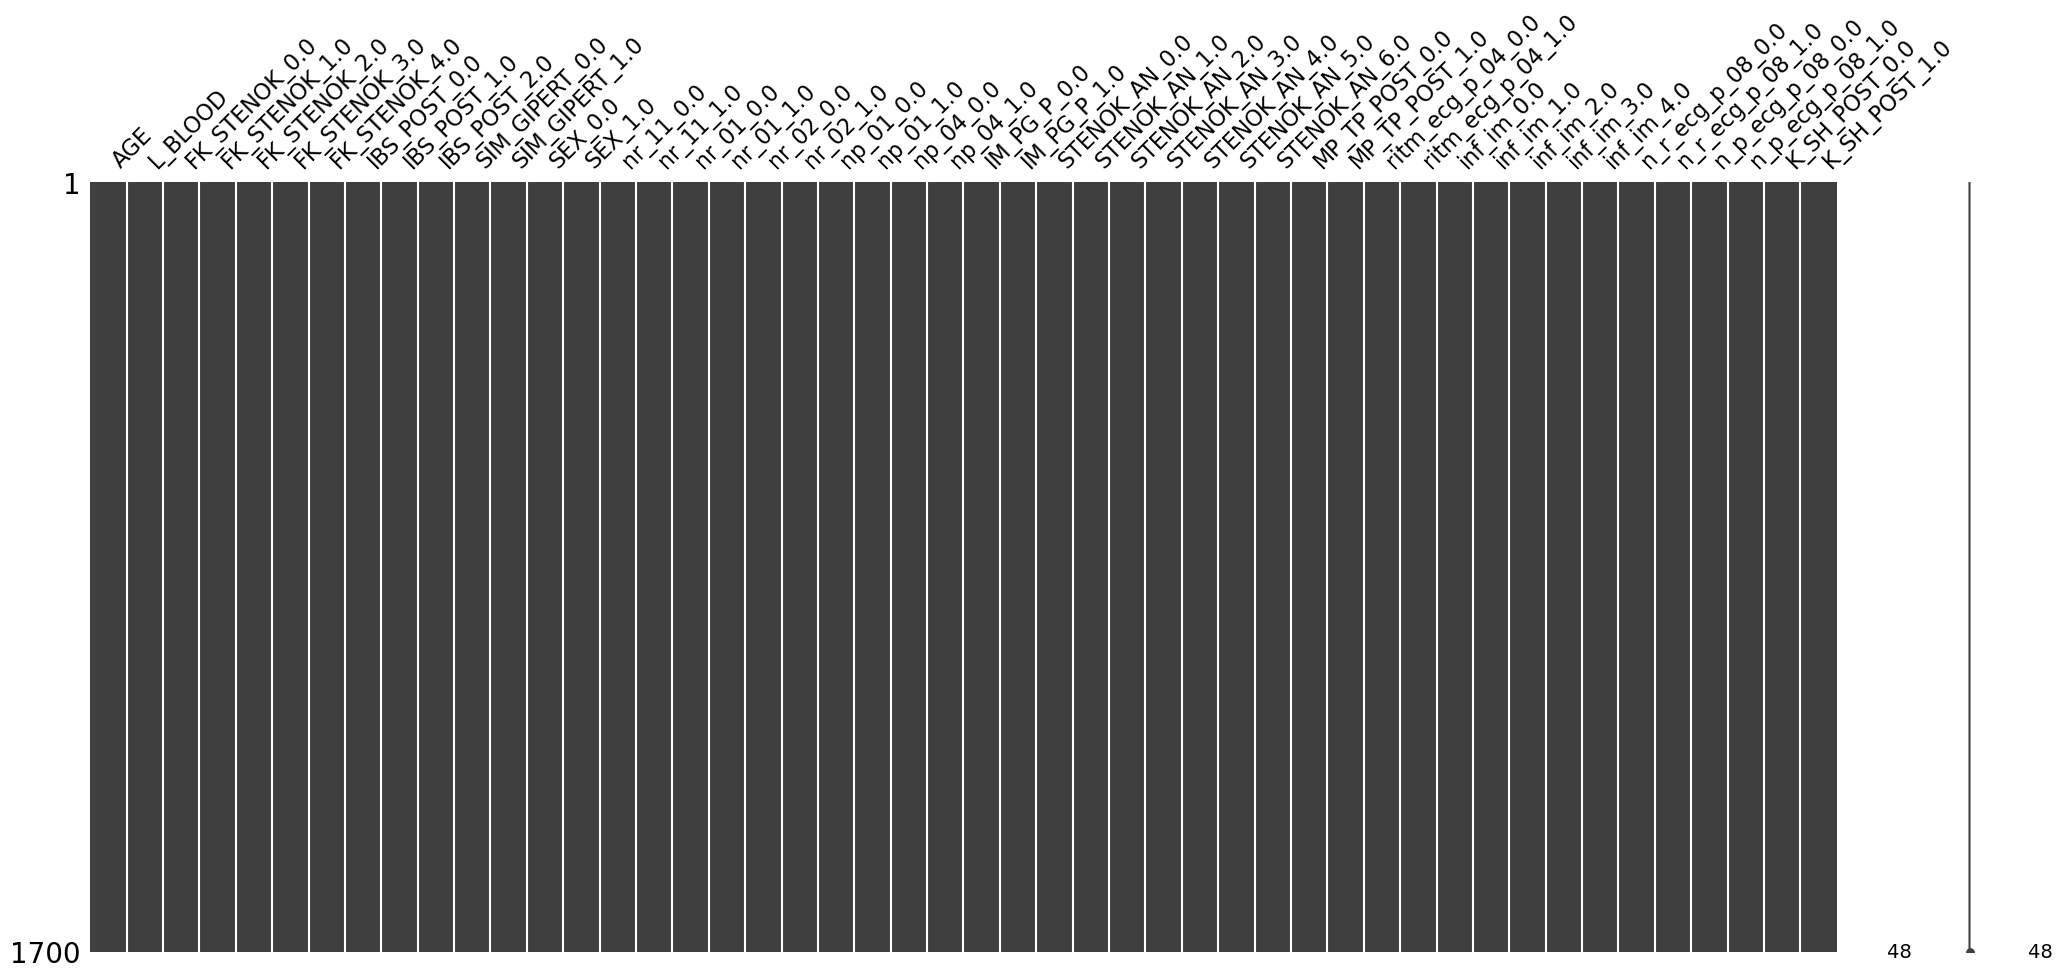

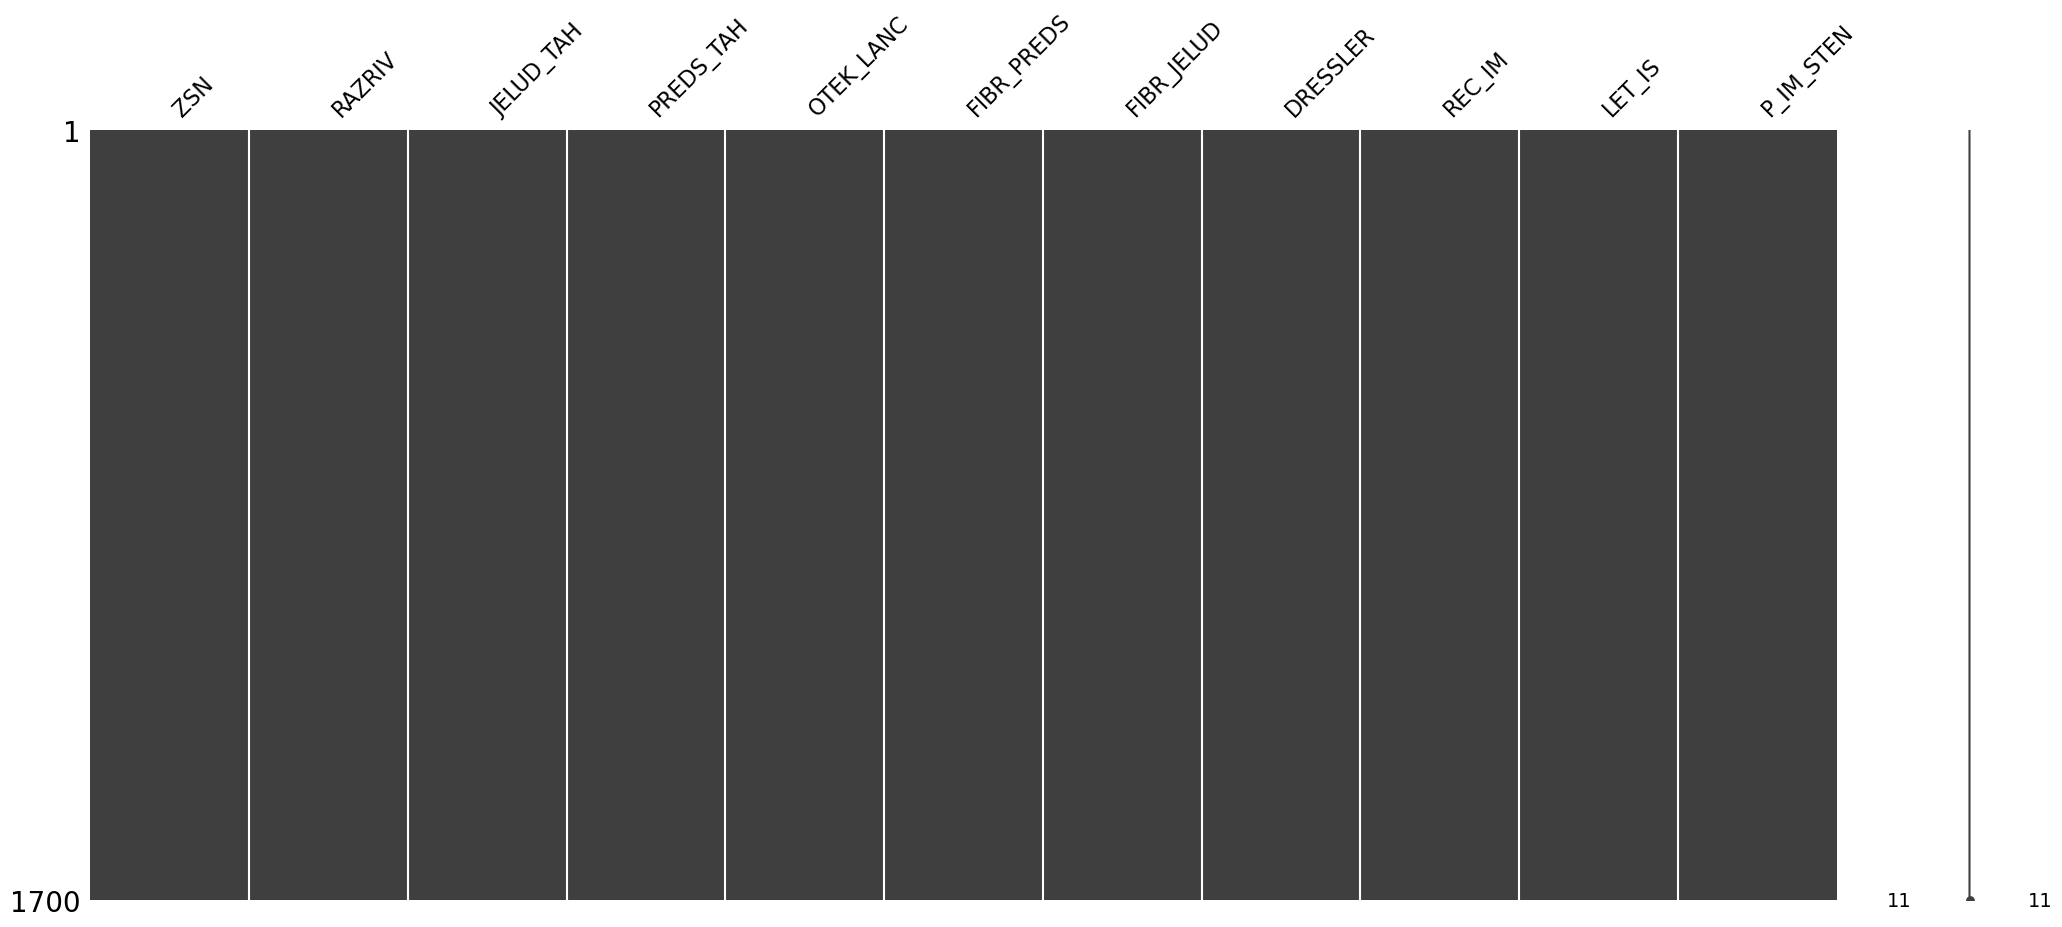

In [79]:
msno.matrix(X_cleaned)
plt.show()

# --- Step 3: Plot Missing Value Matrix (After) ---
msno.matrix(y_cleaned)
plt.show()

### Predict mortality target

In [87]:
# --- Step 1: Binarize the target ---
target_name = 'LET_IS'
y_bin = y[target_name].apply(lambda x: 0 if x == 0 else 1).astype('category')
print('Target distribution:', y_bin.value_counts(normalize=True))

Target distribution: LET_IS
0    0.840588
1    0.159412
Name: proportion, dtype: float64


In [88]:
# --- Step 2: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)

In [89]:
# Separate features
num_features = [col for col in X_train.select_dtypes(include=['float64', 'int64']).columns]
cat_features = [col for col in X_train.select_dtypes(include=['category', 'object']).columns]

In [90]:
# Build column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

In [91]:
# --- Step 4: Define classifiers ---
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42)
}


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       286
           1       0.75      0.28      0.41        54

    accuracy                           0.87       340
   macro avg       0.81      0.63      0.67       340
weighted avg       0.86      0.87      0.84       340


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       286
           1       0.52      0.20      0.29        54

    accuracy                           0.84       340
   macro avg       0.69      0.58      0.60       340
weighted avg       0.81      0.84      0.81       340


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       286
           1       0.39      0.48      0.43        54

    accuracy                           0.80       340
   macro avg       0.65      0.67      0.66       340
w

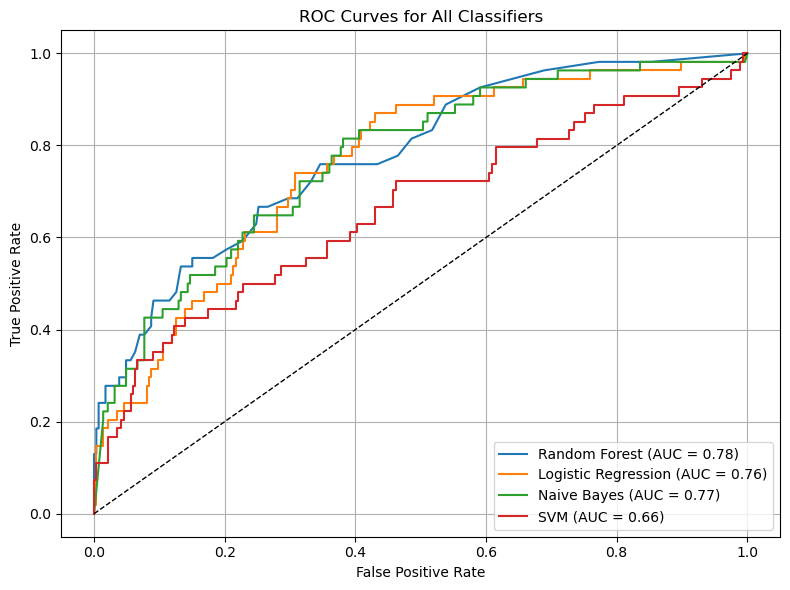

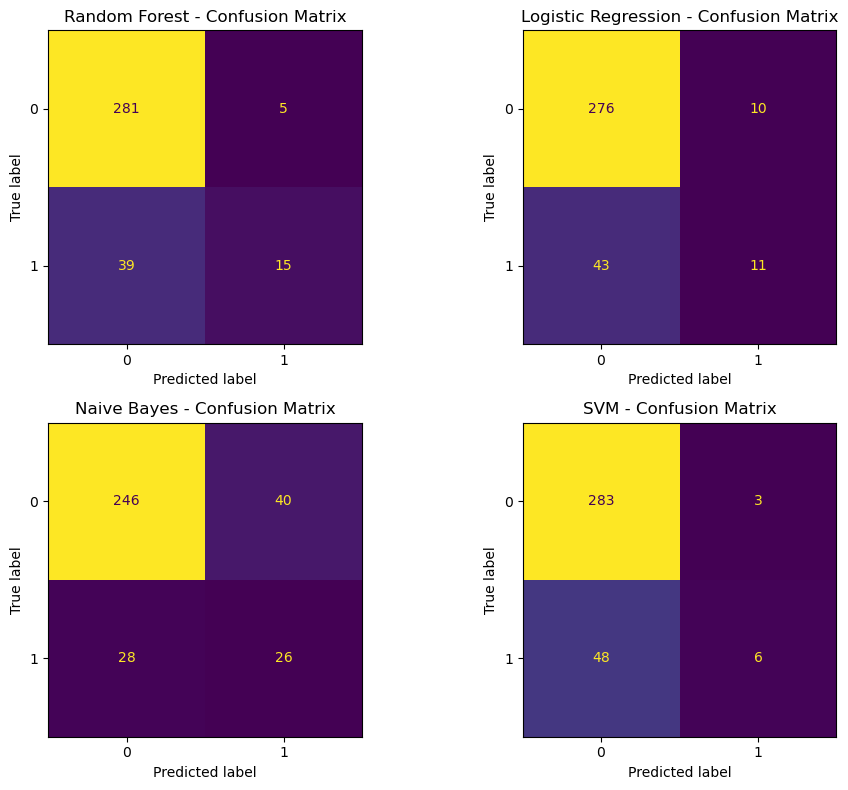

In [94]:
# Store predictions and metrics
roc_data = {}
conf_matrices = {}

# --- Train, evaluate, collect metrics ---
for name, model in classifiers.items():
    print(f"\n=== {name} ===")
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['classifier'], "predict_proba") else None

    # Classification report
    print(classification_report(y_test, y_pred))

    # Store confusion matrix data
    conf_matrices[name] = (y_test, y_pred)

    # Store ROC data if available
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

# --- Plot ROC Curves on One Plot ---
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Classifiers")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Confusion Matrices in Grid ---
n_models = len(conf_matrices)
n_cols = 2
n_rows = (n_models + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for ax, (name, (y_true, y_pred)) in zip(axes.flatten(), conf_matrices.items()):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)
    ax.set_title(f"{name} - Confusion Matrix")

# Remove any empty subplots
for i in range(len(conf_matrices), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [96]:
# --- Create output directory if needed ---
os.makedirs("results", exist_ok=True)

# --- Store metrics for plotting and saving ---
roc_data = {}
conf_matrices = {}
report_dict = {}

# --- Train, evaluate, and collect metrics ---
for name, model in classifiers.items():
    print(f"\n=== {name} ===")
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['classifier'], "predict_proba") else None

    # --- Classification report ---
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # --- Save confusion matrix data ---
    conf_matrices[name] = (y_test, y_pred)

    # --- Save ROC data if available ---
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

    # --- Save metrics for table ---
    report_dict[name] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score']
    }

# --- Create summary table ---
summary_df = pd.DataFrame.from_dict(report_dict, orient='index')
summary_df = summary_df.round(3)
print("\n=== Model Performance Summary ===")
print(summary_df)

# --- Save summary table to CSV ---
summary_df.to_csv("results/model_performance_summary.csv", index=True)

# --- Save ROC curve plot ---
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Classifiers")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/roc_curves.png", dpi=300)
plt.close()

# --- Save confusion matrices as one grid plot ---
n_models = len(conf_matrices)
n_cols = 2
n_rows = (n_models + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for ax, (name, (y_true, y_pred)) in zip(axes.flatten(), conf_matrices.items()):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)
    ax.set_title(f"{name} - Confusion Matrix")

# Remove unused axes if odd number of models
for i in range(len(conf_matrices), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
fig.savefig("results/confusion_matrices.png", dpi=300)
plt.close()


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       286
           1       0.75      0.28      0.41        54

    accuracy                           0.87       340
   macro avg       0.81      0.63      0.67       340
weighted avg       0.86      0.87      0.84       340


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       286
           1       0.52      0.20      0.29        54

    accuracy                           0.84       340
   macro avg       0.69      0.58      0.60       340
weighted avg       0.81      0.84      0.81       340


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       286
           1       0.39      0.48      0.43        54

    accuracy                           0.80       340
   macro avg       0.65      0.67      0.66       340
w